In [1]:
import glob

import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from unseen import fileio
from unseen import independence
from unseen import bias_correction
from unseen import similarity
from unseen import general_utils

## Obs

In [2]:
agcd_file = '/g/data/ia39/agcd/post-processed/data/agcd_v2_precip_total_cafe-grid_monthly_1900-2020.zarr.zip'

In [3]:
#agcd_files = glob.glob('/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_month*.nc')
#agcd_files.sort()
#agcd_files

In [4]:
agcd_ds = fileio.open_dataset(agcd_file,
    variables=['pr'],
    shapefile='wheatbelt.zip',
    spatial_agg='mean',
    time_freq='A-DEC',
    time_agg='sum',
    input_freq='M',
    metadata_file='../../config/dataset_agcd_monthly.yml',
    complete_time_agg_periods=True
)

In [6]:
print(agcd_ds)

<xarray.Dataset>
Dimensions:  (region: 1, time: 121)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2020-12-31 00:00:00
  * region   (region) int64 0
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                   

In [7]:
agcd_ds = agcd_ds.squeeze(drop=True)
agcd_ds = agcd_ds.dropna('time')

In [8]:
print(agcd_ds)

<xarray.Dataset>
Dimensions:  (time: 120)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    pr       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:       

In [9]:
agcd_ds = agcd_ds.compute()

In [10]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

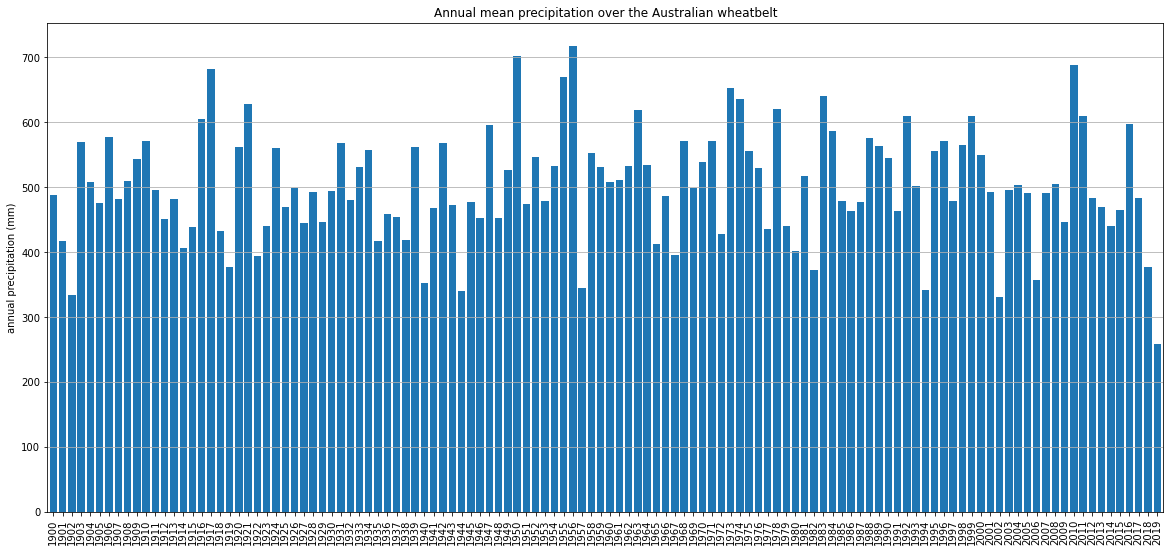

In [11]:
agcd_df['pr'].plot.bar(figsize=[20, 9], width=0.8)
#plt.axhline(mean_rainfall, color='0.5', linestyle='--')
plt.ylabel('annual precipitation (mm)')
plt.title(f'Annual mean precipitation over the Australian wheatbelt')
plt.grid(axis='y')
plt.show()

In [12]:
ranked_years = agcd_df['pr'].sort_values()
ranked_years.head(n=10)

2019    258.772963
2002    331.651974
1902    334.037246
1944    341.258801
1994    341.414517
1957    344.510548
1940    353.472467
2006    357.692126
1982    373.436263
1919    377.921436
Name: pr, dtype: float64

2019 was the driest year on record for Australia. Do the example UNSEEN analysis on that.

## Model

In [13]:
cafe_files1990s = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-199[5,6,7,8,9]*/atmos_isobaric_daily.zarr.zip')
cafe_files2000s = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-2*/atmos_isobaric_daily.zarr.zip')
cafe_files = cafe_files1990s + cafe_files2000s
cafe_files.sort()
print(cafe_files)

['/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19951101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19960501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19961101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19970501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19971101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19980501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19981101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19990501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19991101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20000501/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20001101/atmos_isobaric_daily.zarr.zip',
 '/g/data/xv83/d

In [14]:
cafe_ds = fileio.open_mfforecast(cafe_files,
    variables=['pr'],
    spatial_coords=[-44, -11, 113, 154],
    shapefile='wheatbelt.zip',
    spatial_agg='mean',
    time_freq='A-DEC',
    time_agg='sum',
    input_freq='D',
    reset_times=True,
    metadata_file='../../config/dataset_cafe_monthly.yml',
    complete_time_agg_periods=True,
    units={'pr': 'mm day-1'},
    units_timing='middle'
)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [15]:
cafe_ds = cafe_ds.squeeze(drop=True)

In [16]:
print(cafe_ds)

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 52, lead_time: 11)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
    time       (lead_time, init_date) object 1995-05-01 12:00:00 ... 2030-11-...
Data variables:
    pr         (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 1, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2


In [17]:
cafe_ds = cafe_ds.compute()

In [18]:
cafe_ds['pr'].isel({'ensemble': 1, 'init_date': 2}).values

array([         nan, 295.25228011, 324.1255393 , 450.45456505,
       709.29127258, 628.22588415, 367.16031342, 536.08827853,
       683.38194972, 381.03136122,          nan])

## Independence testing

In [26]:
mean_correlations, null_correlation_bounds = independence.run_tests(cafe_ds['pr'])

In [27]:
print(mean_correlations)

{5: <xarray.DataArray (lead_time: 11)>
dask.array<mean_agg-aggregate, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10, 11: <xarray.DataArray (lead_time: 11)>
dask.array<mean_agg-aggregate, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10}


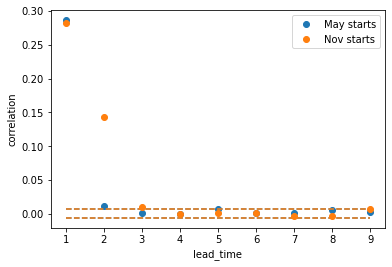

In [28]:
independence.create_plot(
    mean_correlations,
    null_correlation_bounds,
    'wheatbelt_independence.png'
)

So we should drop the first two lead times (TODO: We need a function where we can drop a different number of lead times for each init date).

In [29]:
cafe_da_indep = cafe_ds['pr'].dropna('lead_time').sel({'lead_time': slice(3, None)})

## Bias correction

In [30]:
correction_method = 'additive'
baseline_period = ['2004-01-01', '2019-12-31']

In [31]:
bias = bias_correction.get_bias(
    cafe_da_indep,
    agcd_ds['pr'],
    correction_method,
    time_rounding='A',
    time_period=baseline_period
)
print(bias)

<xarray.DataArray 'pr' (month: 2, lead_time: 4)>
array([[-79.73348325, -66.94647375, -51.25970312, -54.93298978],
       [-65.09246704, -73.51923507, -52.91778398, -45.92252261]])
Coordinates:
  * lead_time  (lead_time) int64 3 4 5 6
  * month      (month) int64 5 11
Attributes:
    cell_methods:            time: mean
    interp_method:           conserve_order1
    long_name:               Total precipitation rate
    time_avg_info:           average_T1,average_T2,average_DT
    units:                   mm d-1
    climatological_period:   ['2004-01-01', '2019-12-31']
    bias_correction_method:  additive
    bias_correction_period:  2004-01-01-2019-12-31


In [32]:
cafe_da_bc = bias_correction.remove_bias(cafe_da_indep, bias, correction_method)

In [33]:
print(cafe_da_bc)

<xarray.DataArray 'pr' (init_date: 52, lead_time: 4, ensemble: 96)>
array([[[524.34334892, 423.72240775, 345.6981328 , ..., 497.035067  ,
         720.96984647, 487.41822556],
        [756.71922122, 502.66832049, 631.11286809, ..., 484.01885366,
         731.01379997, 715.73901964],
        [453.42650452, 448.40739659, 385.7836385 , ..., 548.08953024,
         371.65384747, 390.75545565],
        [542.21469085, 482.31088959, 323.34694558, ..., 406.47430173,
         461.33903561, 397.1072783 ]],

       [[407.50722943, 421.50461423, 518.35997067, ..., 297.58475869,
         659.85189933, 672.84788334],
        [403.60118008, 414.98532039, 515.22784631, ..., 412.39009997,
         578.01441685, 892.4359766 ],
        [543.2960911 , 489.84362415, 433.60395736, ..., 378.36371688,
         586.4444975 , 582.87564883],
        [362.98479252, 449.51819413, 362.15578742, ..., 575.48779724,
         464.06530109, 495.22348724]],

       [[558.07571911, 530.18804829, 450.71580517, ..., 423.0059

In [34]:
cafe_da_bc = cafe_da_bc.compute()

## Similarity testing

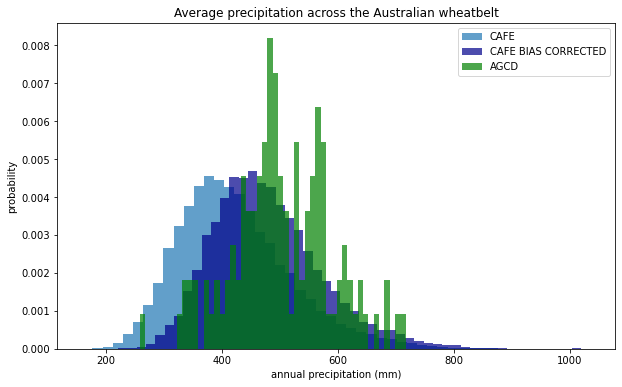

In [35]:
fig = plt.figure(figsize=[10, 6])
cafe_da_indep.plot.hist(
    bins=50, density=True, label='CAFE', alpha=0.7
)
cafe_da_bc.plot.hist(
    bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7
)
agcd_ds['pr'].plot.hist(
    bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7
)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the Australian wheatbelt')
plt.legend()
plt.savefig('wheatbelt_precip_histogram.png',
            bbox_inches='tight', facecolor='white', dpi=200)
plt.show()

In [36]:
time_slice = general_utils.date_pair_to_time_slice(baseline_period)

similarity_ds = similarity.univariate_ks_test(cafe_da_bc, agcd_ds, 'pr')
print(similarity_ds['pval'].values)

[6.25815783e-04 4.22842520e-04 2.35883442e-05 1.61185358e-05]


In [37]:
similarity_ds['ks'].values

array([0.18361378, 0.18802083, 0.21766827, 0.22127404])

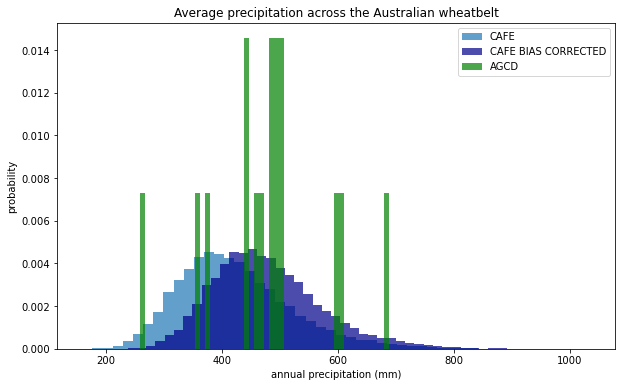

In [38]:
fig = plt.figure(figsize=[10, 6])
cafe_da_indep.plot.hist(
    bins=50, density=True, label='CAFE', alpha=0.7
)
cafe_da_bc.plot.hist(
    bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7
)
agcd_ds['pr'].sel({'time': time_slice}).plot.hist(
    bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7,
)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the Australian wheatbelt')
plt.legend()
plt.show()

In [39]:
similarity.univariate_ks_test(
    cafe_da_bc,
    agcd_ds.sel({'time': time_slice}),
    'pr'
)['pval'].values

array([0.72392362, 0.64508239, 0.46874995, 0.39093143])

In [40]:
similarity.univariate_ks_test(
    cafe_da_bc,
    agcd_ds.sel({'time': time_slice}),
    'pr'
)['ks'].values

array([0.16426282, 0.17588141, 0.20272436, 0.21594551])

In [60]:
test = '/g/data/xv83/dbi599/ag/data/ks-test_pr_cafe-c5-d60-pX-f6_19950501-20191101_A-DEC_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip'

In [61]:
test_ds = fileio.open_dataset(test)

In [80]:
test_ds.sel({'region': 'all'})['pval'].values

array([0.29851961, 0.48370353, 0.80555645, 0.764961  , 0.53110914,
       0.5026992 , 0.49506207, 0.46504714, 0.45281131])

In [81]:
test_ds.sel({'region': 'all'})['ks'].values

array([0.23397436, 0.20032051, 0.15164263, 0.15805288, 0.19290865,
       0.19731571, 0.19851763, 0.20332532, 0.20532853])